<a href="https://colab.research.google.com/github/jollyoli93/KnowYourLoadExactly/blob/main/Crane_Detector_BoundingBoxCrop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import torch

In [3]:
from pathlib import Path

In [4]:
%cd /content/drive/MyDrive/Crane-Detector/Image_Classes

/content/drive/MyDrive/Crane-Detector/Image_Classes


In [5]:
files = [p for p in Path("./").glob("*Unzipped Files*")]

In [6]:
files

[PosixPath('master_project.v17-precast.yolov8-obb (Unzipped Files)'),
 PosixPath('master_project.v16-concrete-skips.yolov8-obb (Unzipped Files)'),
 PosixPath('master_project.v15-beams.yolov8-obb (Unzipped Files)'),
 PosixPath('master_project.v12-formwork.yolov8-obb (Unzipped Files)'),
 PosixPath('master_project.v11-rebar.yolov8-obb (Unzipped Files)'),
 PosixPath('master_project.v18-miscellanous.yolov8-obb (Unzipped Files)'),
 PosixPath('master_project.v19-skip.yolov8-obb (Unzipped Files)')]

In [7]:
def find_centroid(coords):
  xs = 0
  ys = 0

  for i in range(len(coords)):
    if i % 2 == 0:
      xs += coords[i]
    else:
      ys += coords[i]

  xc = xs / (len(coords)/2)
  yc = ys / (len(coords)/2)

  return [xc, yc]

In [8]:
def get_dims(coords):
    xs = coords[::2]
    ys = coords[1::2]

    width = max(xs) - min(xs)
    height = max(ys) - min(ys)

    return [width, height]

In [9]:
def get_crop(file_path):
  """
  Opens yolo txt file and extracts:
    Normalised centroid coordinates >> (x,y)
    Normalised Width and Height >> (w,h)
  """
  file_id = Path(file_path).stem
  print(file_id)

  with open(file_path, "r") as f:
      new_line = f.read().strip().split("\n")

      for i, line in enumerate(new_line):
          if not line.strip():
              continue  # skip empty lines
          else:
            data = line.split()
            class_num = data[0]

            if class_num == '1':
                coords = list(map(float, data[1:]))
                centroid = find_centroid(coords)
                dims = get_dims(coords)
                return {"id": file_id, "centroid": centroid, "dims" : dims}

In [10]:
#   # Get crop data
# trainvalidcrops = dict()
# testcrops = dict()


In [11]:
def crop_load(img, x, y, w, h):
    """
    Crop an image given normalized YOLO format bbox:
    x, y = center coordinates (normalized [0,1])
    w, h = width & height (normalized [0,1])
    """
    img_h, img_w, _ = img.shape

    # scale normalized values to pixel values
    x_center = int(x * img_w)
    y_center = int(y * img_h)
    w = int(w * img_w)
    h = int(h * img_h)

    # calculate box coordinates
    left = max(0, x_center - w // 2)
    right = min(img_w, x_center + w // 2)
    top = max(0, y_center - h // 2)
    bottom = min(img_h, y_center + h // 2)

    # crop
    cropped_img = img[top:bottom, left:right]

    return cropped_img


In [19]:
from pathlib import Path
import cv2

def get_cropped_imgs(file):
  print(file)
  # Extract class name from file naming convention
  file_list = file.name.split(".")
  class_name = file_list[1].split("-")[1]

  print(f"\n--- Processing class: {class_name} ---")

  trainvalidcrops = {class_name: []}
  testcrops = {class_name: []}

  # Define dataset splits
  train_path = file.name + "/train"
  valid_path = file.name + "/valid"
  test_path  = file.name + "/test"

  folders = [train_path, valid_path, test_path]

  for folder in folders:
      label_dir = Path(folder) / "labels"

      for label_file in label_dir.glob("*.txt"):
          crop_data = get_crop(str(label_file))   # expects list/dict of crops
          if not crop_data:
              continue

          centroid = crop_data['centroid']

          dims     = crop_data['dims']
          xc, yc   = centroid
          w, h     = dims

          file_id = label_file.stem
          image_file = Path(folder) / "images" / f"{file_id}.jpg"

          if not image_file.exists():
              print(f"Missing image for {label_file}")
              continue

          img = cv2.imread(str(image_file))
          if img is None:
              print(f"Failed to load {image_file}")
              continue

          crop_img = crop_load(img, xc, yc, w, h)

          if "test" in str(folder):
              testcrops[class_name].append(crop_img)
              print(f"Added test crop for {class_name}: {file_id}")
          else:
              trainvalidcrops[class_name].append(crop_img)
              print(f"Added train/valid crop for {class_name}: {file_id}")

  return trainvalidcrops, testcrops


In [28]:
path = Path('/content/drive/MyDrive/Crane-Detector/Image_Classes/master_project.v19-skip.yolov8-obb (Unzipped Files)')

In [29]:
training_img = []
test_img = []

In [30]:
train, test = get_cropped_imgs(path)

/content/drive/MyDrive/Crane-Detector/Image_Classes/master_project.v19-skip.yolov8-obb (Unzipped Files)

--- Processing class: skip ---
2507031230110000_jpg.rf.4d6b2d4d8a5df3d48b9a37587beaccdb
Added train/valid crop for skip: 2507031230110000_jpg.rf.4d6b2d4d8a5df3d48b9a37587beaccdb
2506031320060000_jpg.rf.f05392a3a5af4f58591ecaf2729bf541
Added train/valid crop for skip: 2506031320060000_jpg.rf.f05392a3a5af4f58591ecaf2729bf541
2507021020110000_jpg.rf.ea1809ce07e27ecb9f13149084902252
Added train/valid crop for skip: 2507021020110000_jpg.rf.ea1809ce07e27ecb9f13149084902252
2506031300060000_jpg.rf.1bd83f92e6bd0037f80dc521f94c77ab
Added train/valid crop for skip: 2506031300060000_jpg.rf.1bd83f92e6bd0037f80dc521f94c77ab
2503031230005276_jpg.rf.7887a1ac9b0e1610bf9ce9e6fadfc620
Added train/valid crop for skip: 2503031230005276_jpg.rf.7887a1ac9b0e1610bf9ce9e6fadfc620
2505070920110000_jpg.rf.3182283b0321ddcffb4d3d3f13038498
Added train/valid crop for skip: 2505070920110000_jpg.rf.3182283b0321ddc

In [31]:
train

{'skip': [array([[[106, 101, 102],
          [103,  99,  98],
          [103,  98,  99],
          ...,
          [105, 130, 150],
          [ 99, 124, 144],
          [ 95, 122, 142]],
  
         [[111, 106, 108],
          [106, 101, 102],
          [100,  95,  97],
          ...,
          [113, 137, 155],
          [110, 134, 152],
          [104, 130, 147]],
  
         [[111, 106, 108],
          [108, 103, 105],
          [107, 102, 104],
          ...,
          [121, 141, 158],
          [121, 144, 160],
          [124, 147, 163]],
  
         ...,
  
         [[204, 201, 203],
          [196, 193, 195],
          [191, 187, 192],
          ...,
          [218, 218, 218],
          [215, 213, 213],
          [214, 212, 211]],
  
         [[209, 207, 207],
          [192, 190, 190],
          [187, 184, 186],
          ...,
          [226, 229, 227],
          [223, 226, 224],
          [217, 220, 218]],
  
         [[198, 196, 196],
          [189, 187, 187],
          [182, 

array([[[106, 101, 102],
        [103,  99,  98],
        [103,  98,  99],
        ...,
        [105, 130, 150],
        [ 99, 124, 144],
        [ 95, 122, 142]],

       [[111, 106, 108],
        [106, 101, 102],
        [100,  95,  97],
        ...,
        [113, 137, 155],
        [110, 134, 152],
        [104, 130, 147]],

       [[111, 106, 108],
        [108, 103, 105],
        [107, 102, 104],
        ...,
        [121, 141, 158],
        [121, 144, 160],
        [124, 147, 163]],

       ...,

       [[204, 201, 203],
        [196, 193, 195],
        [191, 187, 192],
        ...,
        [218, 218, 218],
        [215, 213, 213],
        [214, 212, 211]],

       [[209, 207, 207],
        [192, 190, 190],
        [187, 184, 186],
        ...,
        [226, 229, 227],
        [223, 226, 224],
        [217, 220, 218]],

       [[198, 196, 196],
        [189, 187, 187],
        [182, 180, 180],
        ...,
        [219, 229, 223],
        [216, 226, 220],
        [213, 223, 217]]], dtype=uint8)
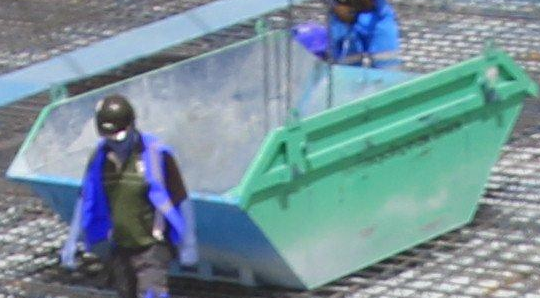

In [33]:
train['skip'][0]

In [ ]:
for file in files:
  train, test = get_cropped_imgs(file)
  training_img.append(train)
  test_img.append(test)


--- Processing class: precast ---
2503151000110000_jpg.rf.e32f97ba0f833f4e661361e3dc83a804
Added train/valid crop for precast: 2503151000110000_jpg.rf.e32f97ba0f833f4e661361e3dc83a804
2506231150110000_jpg.rf.509929f3b9538e40fc4c6c2cac33496e
Added train/valid crop for precast: 2506231150110000_jpg.rf.509929f3b9538e40fc4c6c2cac33496e
2503171220110000_jpg.rf.738fe1a96118c94a872f4b0d7f10c665
Added train/valid crop for precast: 2503171220110000_jpg.rf.738fe1a96118c94a872f4b0d7f10c665
2503170820110000_jpg.rf.04737cfa5f85a7ef75e33d9f1a4f0393
Added train/valid crop for precast: 2503170820110000_jpg.rf.04737cfa5f85a7ef75e33d9f1a4f0393
2503141530110000_jpg.rf.f62b54cd90191520f423c0addb5cc46c
Added train/valid crop for precast: 2503141530110000_jpg.rf.f62b54cd90191520f423c0addb5cc46c
2504120930120000_jpg.rf.7fb791d0174aebeb85b66f67647faf74
Added train/valid crop for precast: 2504120930120000_jpg.rf.7fb791d0174aebeb85b66f67647faf74
2504091032400000_jpg.rf.8a2490909fc5a0af3250777645f01e2e
Added tr

In [ ]:
training_img[2]

{'beams': [array([[[ 64,  96,  91],
          [ 74, 107, 103],
          [ 77, 111, 111],
          ...,
          [198, 193, 194],
          [215, 210, 211],
          [251, 246, 247]],
  
         [[ 74, 101,  97],
          [ 79, 108, 105],
          [ 73, 104, 103],
          ...,
          [194, 189, 190],
          [236, 231, 233],
          [250, 245, 247]],
  
         [[ 71,  94,  89],
          [ 76,  99,  95],
          [ 80, 104, 102],
          ...,
          [178, 173, 175],
          [235, 229, 234],
          [243, 239, 244]],
  
         ...,
  
         [[ 80, 119, 104],
          [ 78, 117, 102],
          [ 60,  99,  84],
          ...,
          [ 95, 141, 128],
          [ 90, 148, 130],
          [ 64, 126, 108]],
  
         [[ 78, 117, 102],
          [ 63,  99,  85],
          [ 42,  78,  64],
          ...,
          [ 89, 136, 120],
          [ 87, 145, 127],
          [ 71, 136, 115]],
  
         [[ 73, 108,  94],
          [ 68, 103,  89],
          [ 51,

In [ ]:
training_img[4]

{'rebar': [array([[[133, 143, 160],
          [126, 135, 149],
          [130, 138, 151],
          ...,
          [109, 121, 131],
          [120, 134, 146],
          [118, 131, 145]],
  
         [[132, 140, 157],
          [126, 135, 149],
          [125, 133, 146],
          ...,
          [126, 138, 150],
          [124, 138, 150],
          [118, 131, 145]],
  
         [[129, 138, 152],
          [126, 135, 148],
          [130, 139, 149],
          ...,
          [124, 136, 148],
          [122, 135, 149],
          [117, 130, 144]],
  
         ...,
  
         [[158, 172, 191],
          [158, 172, 191],
          [156, 170, 189],
          ...,
          [132, 147, 166],
          [138, 152, 171],
          [142, 156, 178]],
  
         [[157, 171, 189],
          [156, 170, 188],
          [158, 172, 191],
          ...,
          [136, 151, 170],
          [133, 148, 167],
          [132, 146, 168]],
  
         [[159, 172, 188],
          [154, 167, 183],
          [160,

In [ ]:
for i in range(0, 50):

  cv2_imshow(training_img[4]['rebar'][i])

In [ ]:
numpy.savetxt("foo.csv", a, delimiter=",")

In [ ]:
from collections import defaultdict
# Convert to grouped dictionary
grouped_data = defaultdict(list)
for item in training_img:
    for label, image in item.items():
        grouped_data[label].append(image)

# Convert back to regular dict if needed
grouped_data = dict(grouped_data)

In [ ]:
grouped_data['rebar']

[[array([[[133, 143, 160],
          [126, 135, 149],
          [130, 138, 151],
          ...,
          [109, 121, 131],
          [120, 134, 146],
          [118, 131, 145]],
  
         [[132, 140, 157],
          [126, 135, 149],
          [125, 133, 146],
          ...,
          [126, 138, 150],
          [124, 138, 150],
          [118, 131, 145]],
  
         [[129, 138, 152],
          [126, 135, 148],
          [130, 139, 149],
          ...,
          [124, 136, 148],
          [122, 135, 149],
          [117, 130, 144]],
  
         ...,
  
         [[158, 172, 191],
          [158, 172, 191],
          [156, 170, 189],
          ...,
          [132, 147, 166],
          [138, 152, 171],
          [142, 156, 178]],
  
         [[157, 171, 189],
          [156, 170, 188],
          [158, 172, 191],
          ...,
          [136, 151, 170],
          [133, 148, 167],
          [132, 146, 168]],
  
         [[159, 172, 188],
          [154, 167, 183],
          [160, 172, 190

In [ ]:
import pickle

with open("cropped_images.pkl", "wb") as f:
    pickle.dump(grouped_data, f)


In [ ]:
with open("cropped_images.pkl", "rb") as f:
    data = pickle.load(f)


In [ ]:
!ls

 cropped_images.pkl
 Images
'master_project.v11-rebar.yolov8-obb (Unzipped Files)'
 master_project.v11-rebar.yolov8-obb.zip
'master_project.v12-formwork.yolov8-obb (Unzipped Files)'
 master_project.v12-formwork.yolov8-obb.zip
'master_project.v15-beams.yolov8-obb (Unzipped Files)'
 master_project.v15-beams.yolov8-obb.zip
'master_project.v16-concrete-skips.yolov8-obb (Unzipped Files)'
 master_project.v16-concrete-skips.yolov8-obb.zip
'master_project.v17-precast.yolov8-obb (Unzipped Files)'
 master_project.v17-precast.yolov8-obb.zip
'master_project.v18-miscellanous.yolov8-obb (Unzipped Files)'
 master_project.v18-miscellanous.yolov8-obb.zip
'master_project.v19-skip.yolov8-obb (Unzipped Files)'
 master_project.v19-skip.yolov8-obb.zip


array([[[ 69,  81,  87],
        [ 70,  82,  86],
        [105, 117, 121],
        ...,
        [129, 140, 144],
        [127, 138, 142],
        [125, 137, 141]],

       [[ 86,  99, 107],
        [137, 153, 159],
        [166, 180, 186],
        ...,
        [128, 139, 143],
        [139, 151, 155],
        [131, 143, 147]],

       [[126, 141, 150],
        [172, 190, 197],
        [168, 184, 191],
        ...,
        [136, 147, 151],
        [134, 146, 150],
        [140, 152, 156]],

       ...,

       [[ 64,  65,  63],
        [ 61,  62,  60],
        [ 59,  59,  59],
        ...,
        [108, 113, 112],
        [133, 138, 139],
        [125, 133, 133]],

       [[ 53,  53,  53],
        [ 50,  50,  50],
        [ 47,  47,  47],
        ...,
        [129, 134, 132],
        [145, 150, 149],
        [126, 132, 131]],

       [[ 51,  51,  51],
        [ 48,  48,  48],
        [ 46,  45,  47],
        ...,
        [132, 135, 133],
        [135, 138, 136],
        [127, 132, 130]]], dtype=uint8)
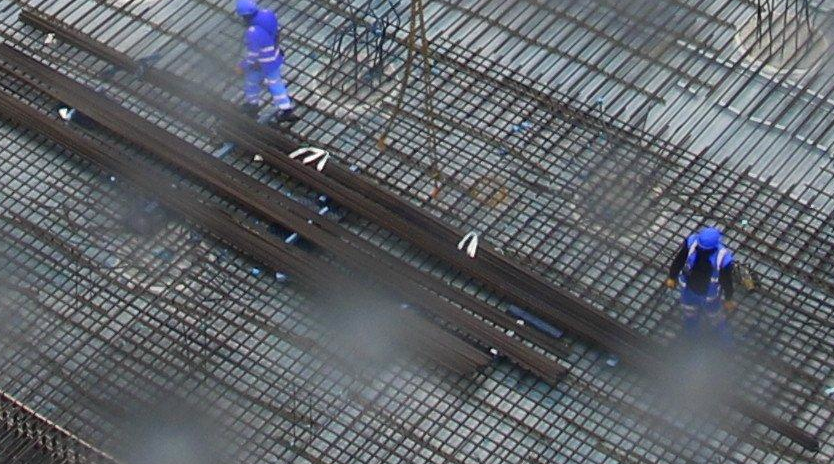

In [ ]:
data['rebar'][0][1]

In [ ]:
# for i, _ in enumerate(trainvalidcrops['skip']):
#   file_id = trainvalidcrops['skip'][i]['id']
#   centroid = trainvalidcrops['skip'][i]['centroid']
#   dims = trainvalidcrops['skip'][i]['dims']

#   xc, yc = centroid
#   w, h = dims

#   for file in Path(test_path).glob(f"{file_id}.jpg"):
#     print(file)
#     img = cv2.imread(str(file))   # read image from path

#     if img is not None:

#         crop = crop_load(img, xc, yc, w, h)
#         imgs.append(crop)
#         # cv2_imshow(crop)
#         # cv2_imshow(img)